# Project: Investigate TMDb Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I have selected TMDb Movie Dataset for this project.


This dataset has around 10K rows with information movies from the movies database (TMDb). The dataset has 21 columns with information like title, budget, cast, director, runtime, vote, genre, revenue etc. Few columns have multiple items separated by a pipe ‘|’ for example cast and genres. Also, I am not sure if it has duplicate rows. I will deal with these in the data cleaning section. 


#### The following questions I would like to explore:
1. Which movie has the Highest and Lowest revenue?
2. What is the trend of average budget and average revenue over the years?
3. Is there any relationship between budget and revenue?
4. What % of high budgeted movies generated high revenue?
5. What is the runtime trend over years?
6. How many movies released each year? Is there any trend?

In [467]:
# Importing the packages I will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [468]:
# load data
df = pd.read_csv('tmdb-movies.csv')
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


### Observation
The currency unit is missing. So we will assume that the currency is USD. Adjusted budget and revenue is in scintific number format. Genre column has multiple items sepearted by pipe.

In [469]:
# want to see the data type for each column
df.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

### Observation
Looks like the release date column needs to be formatted properly

In [470]:
# Want to see the null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

### Observation
There are null values in the dataset.

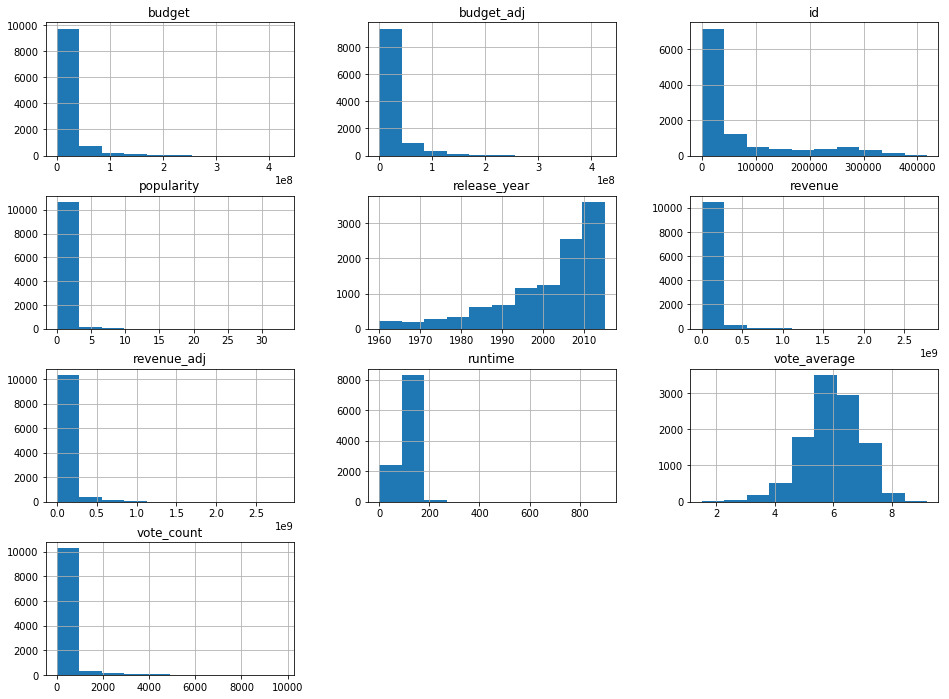

In [471]:
# Want to see if there is any frequency pattern in the dataset
df.hist(figsize=(16,12));

### Observation
From the release year column it is visible that we have more rows for recent years

### Data Cleaning

Steps:

1. For smimplicity, I will drop columns which are not required for my analysis. But these columns might have information for broader analysis. We will keep imdb_id as it looks like as the primary key.
2. I will remove duplicates
3. Convert the date into proper format
4. Convert scintific numbers to regular numbers
6. Then deal with zero values
7. Check the dataset after clean-up

### Drop columns which are not required

In [472]:
# first I will drop the columns, which I don't need to answer my questions
drop_cols = ['id','director','genres','production_companies','popularity','cast', 'budget','revenue','homepage', 'tagline', 'keywords', 'overview','vote_count']

df.drop(drop_cols,1,inplace=True)

### Remove Duplicate Rows

In [473]:
df.drop_duplicates(inplace=True)

### Converting date into proper format

In [474]:
# converting the date into proper format
df['release_date']=pd.to_datetime(df['release_date'],format='%m/%d/%y')

### Converting scintific numbers to integer

In [475]:
# converting scintific nmbers to integer
# I am ignoring the decimals as the number is big
df['budget_adj'] = pd.to_numeric(df['budget_adj'].apply(lambda x: '%.0f' % x))
df['revenue_adj'] = pd.to_numeric(df['revenue_adj'].apply(lambda x: '%.0f' % x))

### Dealing with zero values

In [476]:
# Making the list of the 2 columns
zero_cols = ['budget_adj', 'revenue_adj']

# Replacing all the 0 values with NaN
df[zero_cols] = df[zero_cols].replace(0, np.NAN)

In [477]:
# let's see the null value counts
print('Total number of rows: ',df.shape[0])
df.isnull().sum()

Total number of rows:  10865


imdb_id             10
original_title       0
runtime              0
release_date         0
vote_average         0
release_year         0
budget_adj        5696
revenue_adj       6016
dtype: int64

We can see >50% rows have nan values.

It is dangerous to remove > 50% data from the dataset. We can fill them with average but for simplicity I will take the brave step and remove the rows.

In [478]:
# Delete rows with null
df.dropna(subset = zero_cols, inplace = True)

# Check the dataset
print('Total number of rows: ',df.shape[0])
df.isnull().sum()

Total number of rows:  3854


imdb_id           0
original_title    0
runtime           0
release_date      0
vote_average      0
release_year      0
budget_adj        0
revenue_adj       0
dtype: int64

### Check the dataset after clean-up

In [479]:
#check the dataset after cleanup
df.head(2)

,imdb_id,original_title,runtime,release_date,vote_average,release_year,budget_adj,revenue_adj
0,tt0369610,Jurassic World,124,2015-06-09,6.5,2015,137999939.0,1.392446e+09
1,tt1392190,Mad Max: Fury Road,120,2015-05-13,7.1,2015,137999939.0,3.481613e+08


Everything looks good Now let's move on to the next section to answer our questions.

<a id='eda'></a>
## Exploratory Data Analysis

Now we will try to find out the answers to the following questions:

1. Which movie has the Highest and Lowest revenue?
2. What is the trend of average budget and average revenue over the years?
3. Is there any relationship between budget and revenue?
4. What % of high budgeted movies generated high revenue?
5. What is the runtime trend over years?
6. How many movies released each year? Is there any trend?



### Question 1: Which Movie Has The Highest Or Lowest Profit?

In [480]:
max_index = df['revenue_adj'].idxmax()
print('Movie which generated the highest revenue({}) is {}'
      .format(df['revenue_adj'][max_index],df['original_title'][max_index]))

min_index = df['revenue_adj'].idxmin()
print('Movie which generated the lowest revenue({}) is {}'
      .format(df['revenue_adj'][min_index],df['original_title'][min_index]))

Movie which generated the highest revenue(2827123750.0) is Avatar
Movie which generated the lowest revenue(2.0) is Shattered Glass


Observation: There are still outliers in the dataset. Revenue for Shattered Glass looks wrong. For simplicity we will ignore this.

### Question 2: What is the trend of average budget and average revenue over the years?

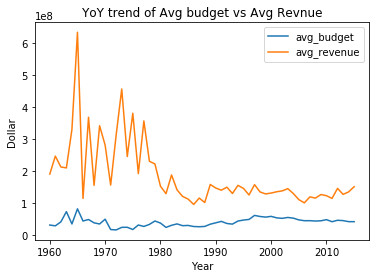

In [481]:
# make the dataset for the avg budget and revenue
year_avg = df.groupby(['release_year'],as_index=False)['budget_adj','revenue_adj'].mean()

# Plot the data in the chart
plt.plot(year_avg['release_year'],year_avg['budget_adj'],label = 'avg_budget');
plt.plot(year_avg['release_year'],year_avg['revenue_adj'],label = 'avg_revenue');
plt.title('YoY trend of Avg budget vs Avg Revnue')
plt.xlabel('Year')
plt.ylabel('Dollar')
plt.legend(loc="upper right")
plt.show()

### Question 3: Is there any relationship between budget and revenue?

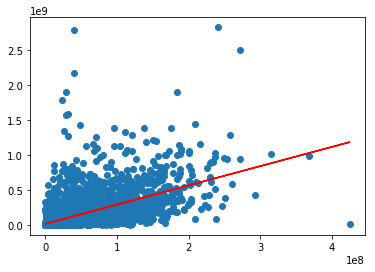

r value:  0.5704510196260754


In [496]:
# defining x and y
x = df['budget_adj']
y = df['revenue_adj']

# calculating the measures
slope, intercept, r, p, std_err = stats.linregress(x, y)

# function to get the slope
def myfunc(x):
  return slope * x + intercept

# running the function 
mymodel = list(map(myfunc, x))

#plotting the data
plt.scatter(x, y)
plt.plot(x, mymodel, color='red')
plt.show()
print('r value: ', r)

Answer: From the scatter plot and r value I can say Budget and Revenue are positively related but the relationship is not very strong.

### Question 4: What % of high budgeted movies generated high revenue?

This is a tricky question. First of all, we need to define what is high budget and high revenue. The following slabs are being used to determine the level for budget and revenue.

1. Low> 25%
2. Medium: >25%  but <50%
3. Moderately High: >50%  but <75%
4. High: >75%

In [562]:
# Let's check the min, 25%, 50%, 75% and max values for budget and revenue
df.describe()[3:]

,runtime,vote_average,release_year,budget_adj,revenue_adj
min,15.0,2.2,1960.0,1.0,2.000000e+00
25%,95.0,5.7,1995.0,13090528.0,1.835735e+07
50%,106.0,6.2,2004.0,30016111.5,6.173068e+07
75%,119.0,6.7,2010.0,60613070.0,1.632577e+08
max,338.0,8.4,2015.0,425000000.0,2.827124e+09


In [568]:
# Level edges (min, 25%, 50%, 75%, max) that will be used to "cut" the data into groups
budget_edges = df.describe()[3:]['budget_adj'].values
revenue_edges = df.describe()[3:]['revenue_adj'].values

In [569]:
# Labels for the four acidity level groups
level_names = ['Low','Medium','Moderately high','High' ]

In [570]:
#Creates acidity_levels column
df['budget_level'] = pd.cut(df['budget_adj'], budget_edges, labels=level_names)
df['revenue_level'] = pd.cut(df['revenue_adj'], revenue_edges, labels=level_names)

# Checks for successful creation of this column
df.head()

,imdb_id,original_title,runtime,release_date,vote_average,release_year,budget_adj,revenue_adj,budget_level,revenue_level
0,tt0369610,Jurassic World,124,2015-06-09,6.5,2015,137999939.0,1.392446e+09,High,High
1,tt1392190,Mad Max: Fury Road,120,2015-05-13,7.1,2015,137999939.0,3.481613e+08,High,High
2,tt2908446,Insurgent,119,2015-03-18,6.3,2015,101199955.0,2.716190e+08,High,High
3,tt2488496,Star Wars: The Force Awakens,136,2015-12-15,7.5,2015,183999919.0,1.902723e+09,High,High
4,tt2820852,Furious 7,137,2015-04-01,7.3,2015,174799923.0,1.385749e+09,High,High


In [571]:
df.groupby(["budget_level","revenue_level"]).size().unstack(level=1).agg(lambda x: x*100/x.sum())

revenue_level,Low,Medium,Moderately high,High
budget_level,,,,
Low,59.625390,25.337487,10.072690,5.082988
Medium,25.806452,36.033229,28.141225,9.854772
Moderately high,11.134235,28.452752,38.317757,22.199170
High,3.433923,10.176532,23.468328,62.863071


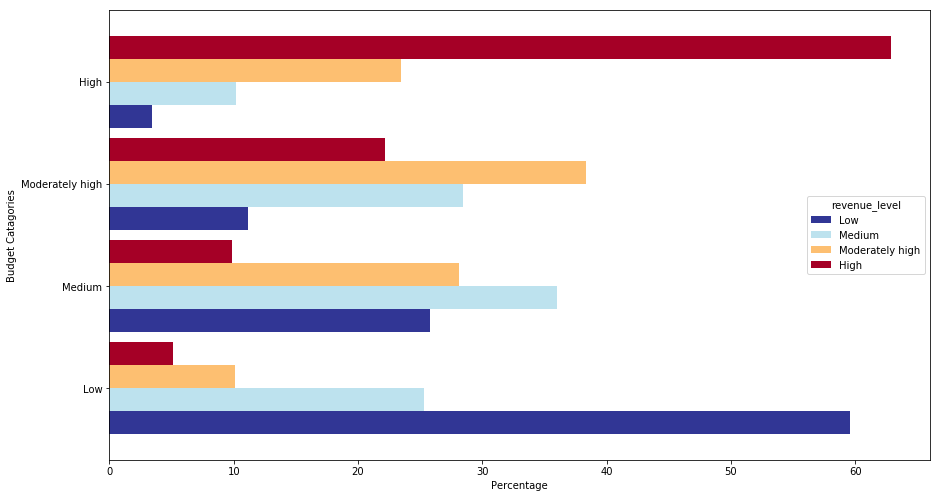

In [572]:
df.groupby(["budget_level","revenue_level"]).size().unstack(level=1).agg(
    lambda x: x*100/x.sum()).plot.barh(figsize = [14.7, 8.27],width = 0.9, cmap = 'RdYlBu_r');

plt.xlabel('Percentage')
plt.ylabel('Budget Catagories');

### Question 5: What is the runtime trend over years?

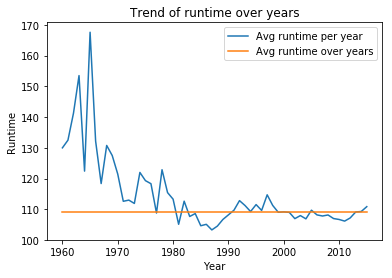

In [547]:
# create the dataset with avg runtime by year and over year
runtime_avg_by_year = df.groupby(['release_year'],as_index=False)['release_year','runtime'].mean()
runtime_avg_by_year['runtime_avg'] = df['runtime'].mean()

# plotting them on the chart
plt.plot(runtime_avg_by_year['release_year'],runtime_avg_by_year['runtime'],label="Avg runtime per year")
plt.plot(runtime_avg_by_year['release_year'],runtime_avg_by_year['runtime_avg'],label="Avg runtime over years")
plt.ylabel('Runtime')
plt.xlabel('Year')
plt.title('Trend of runtime over years')
plt.legend(loc="upper right")
plt.show();

The trend simply says that the runtime has gone down over the years and currently it is at the average over all the years.

### Question 6: How many movies released each year? Is there any trend?

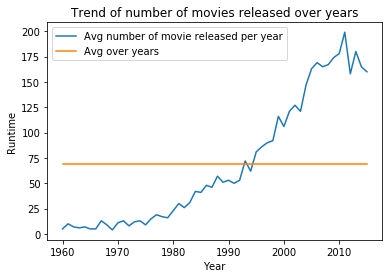

In [495]:
# create the dataset with count of releases per year and over year
df_release_count = df.groupby(['release_year'],as_index=False)['original_title'].count()
df_release_count['avg over years'] = df_release_count['original_title'].mean()


# plotting them on the chart
plt.plot(df_release_count ['release_year'],
         df_release_count ['original_title'],label="Avg number of movie released per year")

plt.plot(df_release_count ['release_year'],
         df_release_count ['avg over years'],label="Avg over years")

plt.ylabel('Runtime')
plt.xlabel('Year')
plt.title('Trend of number of movies released over years')
plt.legend(loc="upper left")
plt.show();

The trend shows that the number of movies released has consistently increased over the years.


<a id='conclusions'></a>
## Conclusions

Overall, I the analysis gives us the following observations:
1.	Average revenue per movie has significantly decreased post 1975. This could be due to high number of movie releases. People have more options. I assume.
2.	On the other hand average budget was more or less consistent.
3.	Though there is a positive relationship between budget and revenue, but it is not strong. Additionally, 63% of the high budgeted movies earned high revenue.
4.	Over the years runtime has gone down. Specifically, after around 1978. But the budget did not reduce much so I assume movie makers were focusing more on quality then time.
5.	It clearly shows that number of movies has gone up over the years but there is a dip after 2009.

### Limitations

1. There were many missing information. So during the data cleaning process I have removed more than 50% of rows. The observations are limited and restricted to selected data. The insights might change if we get large dataset.
2. Though my observation says that high budget leads to high revenue to some extent but there is no gaurantee.



## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [493]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset_Final.ipynb'])

0